In [454]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd
import os# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
#from tarfile import TarFile

#TarFile.open("",'r')

#os.mkdir("/kaggle/working/image")
#os.mkdir("/kaggle/working/mask")
for i in ["/kaggle/working/image","/kaggle/working/mask"]:
    for j in os.listdir(i):
        os.unlink(os.path.join(i,j))
# Any results you write to the current directory are saved as output.

In [455]:
#from tarfile import TarFile
#TarFile.open("/kaggle/input/epithelium-segmentation/nuclei.tgz").extractall()

In [456]:
import matplotlib.pyplot as plt
import matplotlib.image as im
import keras
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Activation,Input,BatchNormalization,Conv2DTranspose,concatenate
from keras.models import Sequential
from keras.utils import Sequence
from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

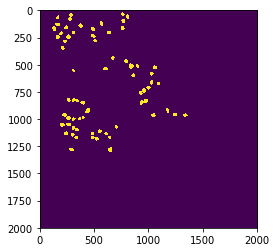

In [457]:
for i in os.listdir("/kaggle/working"):
    img = im.imread(os.path.join("/kaggle/working",i))
    plt.imshow(img)
    break

In [458]:
image_shape=img.shape
image_shape

(2000, 2000)

In [459]:
#os.mkdir("/kaggle/working/image")
#os.mkdir("/kaggle/working/mask")

In [460]:
#uncomment to make image,mask directory

image_path=[]
mask_path=[]

for i in os.listdir("/kaggle/working"):
    if "_original" in i:
        image_path.append(i)
    elif "_mask" in i:
        mask_path.append(i)
        

In [461]:
print(len(image_path),len(mask_path))

total_number_of_images = len(image_path)
path = "/kaggle/working"

141 141


In [462]:
class Data_Generator(Sequence):
    
    def __init__(self,path,image_path,batch_size=32,total_number_of_images=141,number_of_channels=3,
                  dim=(2000,2000),new_dim=(128,128)):
        self.path=path
        self.image_path=image_path
        self.batch_size = batch_size
        self.total_number_of_images=total_number_of_images
        self.number_of_channels=number_of_channels
        self.dim=dim
        self.new_dim=new_dim
        self.len = self.__len__()
    
    def __len__(self):
        return (self.total_number_of_images//self.batch_size)
    
    def __getitem__(self,index):
        img1 = self.get_image(os.path.join(self.path,self.image_path[index]))
        img2 = self.get_image(os.path.join(self.path,self.image_path[index]).replace("_original.tif","_mask.png"))
        
        self.patch_generator(img1,img2,self.image_path[index])
        
        
    
    def patch_generator(self,img1,img2,image_name):
        
        count  = 0 ;
        for i in range(128,self.dim[0],128):
            for j in range(128,self.dim[1],128):
                count =count + 1
                image = cv2.resize(img1[i-128:i,j-128:j],self.new_dim)
                mask = cv2.resize(img2[i-128:i,j-128:j],self.new_dim)
                cv2.imwrite(os.path.join(self.path+"/image",image_name).replace("_original.tif",str(count)+".png"),image)
                cv2.imwrite(os.path.join(self.path+"/mask",image_name).replace("_original.tif",str(count)+".png"),mask)
                
                #print(os.path.join(self.path+"/image",image_name).replace("_original.tif",str(count)+".png"))
                #print(os.path.join(self.path+"/mask",image_name).replace("_original.tif",str(count)+".png"))
             
                
            
    
    def get_image(self,path):
        img  = im.imread(path)
        #img = img/255
        
        return img

In [463]:
path = "/kaggle/working"
image_name = image_path[0]
count=1
print(os.path.join(path+"/image",image_name).replace(".tif",str(count)+".png"))
print(os.path.join(path+"/mask",image_name).replace("_original.tif","_mask"+str(count)+".png"))

/kaggle/working/image/14153_500_f00019_original1.png
/kaggle/working/mask/14153_500_f00019_mask1.png


In [1]:
data_generator = Data_Generator(path,image_path)

for i in range(total_number_of_images):
    data_generator.__getitem__(i)
    

In [465]:
print(len(os.listdir("/kaggle/working/image")),len(os.listdir("/kaggle/working/mask")))

31725 31725


In [466]:
image_paths = os.listdir("/kaggle/working/image")
path = "/kaggle/working"

In [467]:
class Data_Generator(Sequence):
    
    def __init__(self,path,image_paths,total_number_of_images,batch_size=32,number_of_channels=3,
                  dim=(128,128),labels=["image","maks"]):
        self.path=path
        self.image_paths=image_paths
        self.batch_size = batch_size
        self.total_number_of_images=total_number_of_images
        self.number_of_channels=number_of_channels
        self.dim=dim
        #self.new_dim=new_dim
        self.len = self.__len__()
        
    
    def __len__(self):
        return (self.total_number_of_images//self.batch_size)
    
    def __getitem__(self,index):
        #l1 = []
        #l2=[]
        img1 = self.get_image(os.path.join(self.path+"/image",self.image_paths[index]))
        img2 = self.get_image(os.path.join(self.path+"/mask",self.image_paths[index]))
        #l1.append(img1)
        #l2.append(img2)
        #self.patch_generator(img1,img2,self.image_path[index])
        return (img1.reshape(1,*img1.shape),img2.reshape(1,*img2.shape,1))
        #return (img1.reshape(1,*img1.shape),img2.reshape(*img2.shape,1))
    
        
    def get_image(self,path):
        img  = im.imread(path)
        #img = img/255
        
        return img

In [468]:
x = 31725
train_image = image_paths[:23793]
validation_image = image_paths[23793:]

In [469]:
print(len(train_image),len(validation_image))

23793 7932


In [470]:
train_data =  Data_Generator(path,train_image,len(train_image))
validation_data = Data_Generator(path,validation_image,len(validation_image))

In [471]:
print(len(train_data),len(validation_data))

743 247


In [472]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    #model = Sequence()
    #model.add()
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    #print(outputs)
    return model

model = get_unet(Input((128,128, 3)))
model.summary()


Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_623 (Conv2D)             (None, 128, 128, 16) 448         input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_338 (BatchN (None, 128, 128, 16) 64          conv2d_623[0][0]                 
__________________________________________________________________________________________________
activation_338 (Activation)     (None, 128, 128, 16) 0           batch_normalization_338[0][0]    
___________________________________________________________________________________________

In [473]:
'''import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras import backend as tensorflow

from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping


def unet(pretrained_weights = None,input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    return model

model = unet()
'''

"import numpy as np \nimport os\nimport skimage.io as io\nimport skimage.transform as trans\nimport numpy as np\nfrom keras.models import *\nfrom keras.layers import *\nfrom keras.optimizers import *\nfrom keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping\nfrom keras import backend as tensorflow\n\nfrom keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping\n\n\ndef unet(pretrained_weights = None,input_size = (128,128,3)):\n    inputs = Input(input_size)\n    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)\n    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)\n    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)\n    pool2 =

In [474]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [475]:
mod=model.fit_generator(generator=train_data,epochs=20,validation_data=validation_data,shuffle=True,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/1
743/743 [==============================] - 87s 118ms/step - loss: 0.0836 - accuracy: 0.9746 - val_loss: 0.0079 - val_accuracy: 0.9763
